In [1]:
import numpy as np
import matplotlib.pyplot as plt

3.2 Roeの近似リーマン解

図3.5のパラメータに近いもの（バルク速度なし）

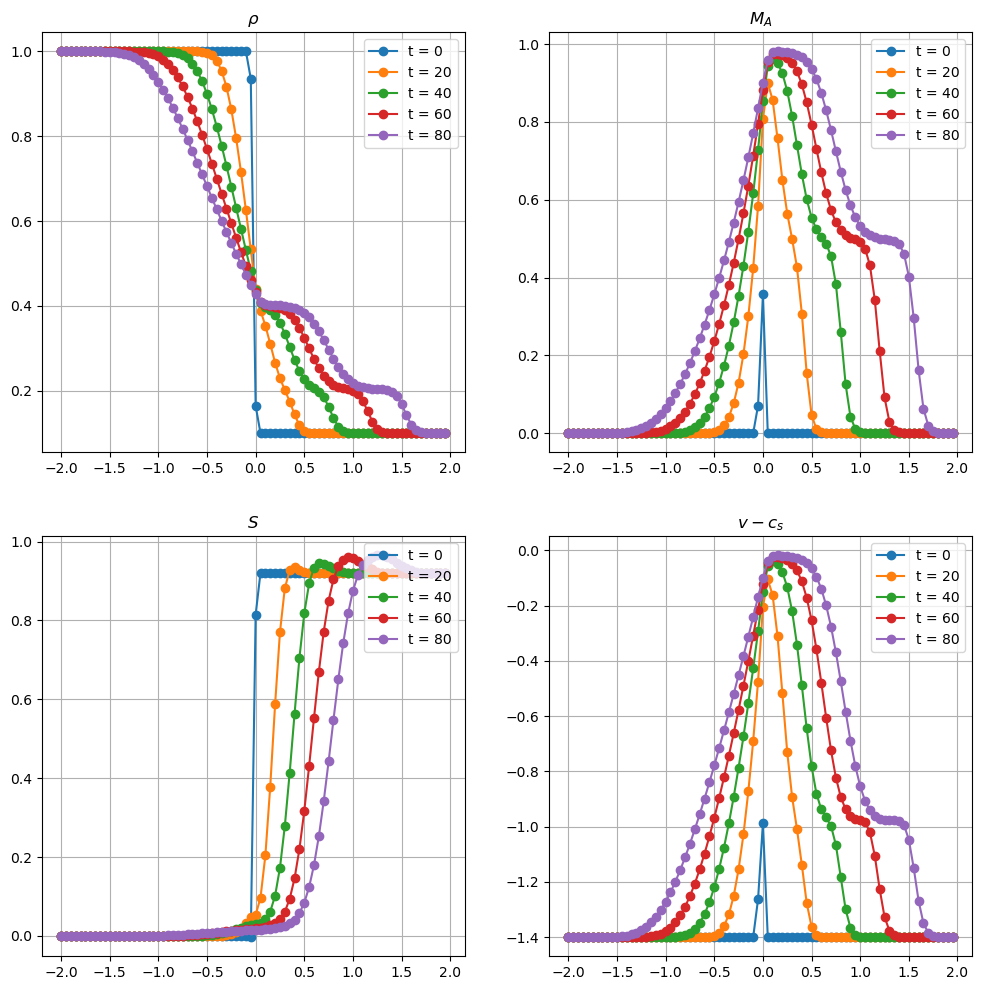

In [51]:
dx = 0.05
dt = 0.01
x = np.arange(-2, 2, dx)
nmax = len(x)

gamma = 1.4

rho_L = 1.0
p_L = 1.0
v_L = 0.0
rho_R = 0.1
p_R = 0.1
v_R = 0.0

U = np.zeros([x.shape[0], 3]) #rho, rho * v, rho * E 
U[x < 0, 0] = rho_L
U[x >= 0, 0] = rho_R
U[x < 0, 1] = rho_L * v_L
U[x >= 0, 1] = rho_R * v_R
U[x < 0, 2] = rho_L * (p_L/(rho_L*(gamma-1)) + v_L**2/2)
U[x >= 0, 2] = rho_R * (p_R/(rho_R*(gamma-1)) + v_R**2/2)

F = np.zeros([x.shape[0], 3])
F_roe = np.zeros([x.shape[0], 3])

fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

step = 80
for t in range(step+1):
    rho = U[:, 0]
    v = U[:, 1] / rho 
    E = U[:, 2] / rho
    H = gamma * E - (gamma-1)/2 * v**2
    p = (H - E) * rho 
    
    rho_ave = np.sqrt(rho * np.roll(rho, -1))
    v_ave = (v * np.sqrt(rho) + np.roll(v, -1) * np.sqrt(np.roll(rho, -1))) / (np.sqrt(rho) + np.sqrt(np.roll(rho, -1)))
    H_ave = (H * np.sqrt(rho) + np.roll(H, -1) * np.sqrt(np.roll(rho, -1))) / (np.sqrt(rho) + np.sqrt(np.roll(rho, -1)))
    cs_ave = (gamma-1) * (H_ave - v_ave**2/2)

    lambda_1 = v_ave - cs_ave
    lambda_2 = v_ave 
    lambda_3 = v_ave + cs_ave
    r1 = np.array([np.ones(v_ave.shape[0]), v_ave - cs_ave, H_ave - v_ave*cs_ave]).T 
    r2 = np.array([np.ones(v_ave.shape[0]), v_ave, v_ave**2/2]).T
    r3 = np.array([np.ones(v_ave.shape[0]), v_ave + cs_ave, H_ave + v_ave*cs_ave]).T

    delta_rho = np.roll(rho, -1) - rho 
    delta_v = np.roll(v, -1) - v 
    delta_p = np.roll(p, -1) - p 
    delta_w = np.array([rho_ave/2/cs_ave * (delta_p/rho_ave/cs_ave - delta_v), 
                        delta_rho - delta_p/cs_ave**2, 
                        rho_ave/2/cs_ave * (delta_p/rho_ave/cs_ave + delta_v)
                        ])
    F[:, 0] = rho * v 
    F[:, 1] = rho * v**2 + p 
    F[:, 2] = rho * H * v 

    #どうにかまとめてできるはずだけど、とりあえずパスで
    F_roe[:, 0] = 1/2 * (F[:, 0] + np.roll(F[:, 0], -1)) \
                - 1/2 * (np.abs(lambda_1) * delta_w[0] * r1[:, 0]
                 + np.abs(lambda_2) * delta_w[1] * r2[:, 0]
                 + np.abs(lambda_3) * delta_w[2] * r3[:, 0])
    F_roe[:, 1] = 1/2 * (F[:, 1] + np.roll(F[:, 1], -1)) \
                - 1/2 * (np.abs(lambda_1) * delta_w[0] * r1[:, 1]
                 + np.abs(lambda_2) * delta_w[1] * r2[:, 1]
                 + np.abs(lambda_3) * delta_w[2] * r3[:, 1])
    F_roe[:, 2] = 1/2 * (F[:, 2] + np.roll(F[:, 2], -1)) \
                - 1/2 * (np.abs(lambda_1) * delta_w[0] * r1[:, 2]
                 + np.abs(lambda_2) * delta_w[1] * r2[:, 2]
                 + np.abs(lambda_3) * delta_w[2] * r3[:, 2])
    
    U += -dt/dx * (F_roe - np.roll(F_roe, 1, axis=0))

    #対称境界条件にした
    U[0, :] = U[1, :]
    U[-1, :] = U[-2, :]
 
    #出力
    if t % 20 == 0:
        rho = U[:, 0]
        v = U[:, 1] / rho 
        E = U[:, 2] / rho
        H = gamma * E - (gamma-1)/2 * v**2
        p = (H - E) * rho 
        cs = (gamma-1) * (H - v**2/2)
        M_A = v / cs
        entropy = np.log(p / rho**gamma)

        ax1.plot(x, rho, marker='o', label=f't = {t}')
        ax2.plot(x, M_A, marker='o', label=f't = {t}')
        ax3.plot(x, entropy, marker='o', label=f't = {t}')
        ax4.plot(x, v - cs, marker='o', label=f't = {t}')

ax1.set_title(r"$\rho$")
ax2.set_title(r"$M_A$")
ax3.set_title(r"$S$")
ax4.set_title(r"$v - c_s$")
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
ax3.legend(loc='upper right')
ax4.legend(loc='upper right')
plt.show()

図3.5のパラメータで（バルク速度あり）

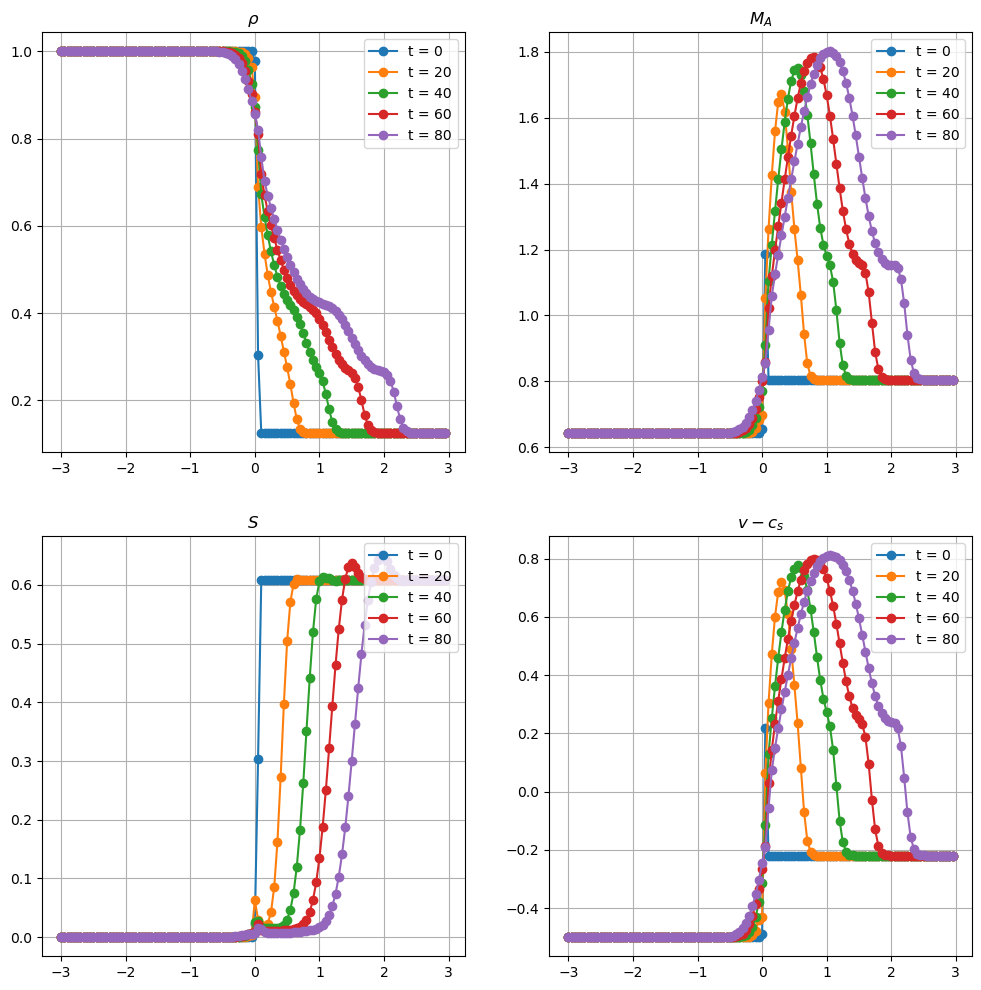

In [49]:
dx = 0.05
dt = 0.01
x = np.arange(-3, 3, dx)
nmax = len(x)

gamma = 1.4

rho_L = 1.0
p_L = 1.0
v_L = 0.9
rho_R = 0.125
p_R = 0.1
v_R = 0.9

U = np.zeros([x.shape[0], 3]) #rho, rho * v, rho * E 
U[x < 0, 0] = rho_L
U[x >= 0, 0] = rho_R
U[x < 0, 1] = rho_L * v_L
U[x >= 0, 1] = rho_R * v_R
U[x < 0, 2] = rho_L * (p_L/(rho_L*(gamma-1)) + v_L**2/2)
U[x >= 0, 2] = rho_R * (p_R/(rho_R*(gamma-1)) + v_R**2/2)

F = np.zeros([x.shape[0], 3])
F_roe = np.zeros([x.shape[0], 3])

fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

step = 80
for t in range(step+1):
    rho = U[:, 0]
    v = U[:, 1] / rho 
    E = U[:, 2] / rho
    H = gamma * E - (gamma-1)/2 * v**2
    p = (H - E) * rho 
    
    rho_ave = np.sqrt(rho * np.roll(rho, -1))
    v_ave = (v * np.sqrt(rho) + np.roll(v, -1) * np.sqrt(np.roll(rho, -1))) / (np.sqrt(rho) + np.sqrt(np.roll(rho, -1)))
    H_ave = (H * np.sqrt(rho) + np.roll(H, -1) * np.sqrt(np.roll(rho, -1))) / (np.sqrt(rho) + np.sqrt(np.roll(rho, -1)))
    cs_ave = (gamma-1) * (H_ave - v_ave**2/2)

    lambda_1 = v_ave - cs_ave
    lambda_2 = v_ave 
    lambda_3 = v_ave + cs_ave
    r1 = np.array([np.ones(v_ave.shape[0]), v_ave - cs_ave, H_ave - v_ave*cs_ave]).T 
    r2 = np.array([np.ones(v_ave.shape[0]), v_ave, v_ave**2/2]).T
    r3 = np.array([np.ones(v_ave.shape[0]), v_ave + cs_ave, H_ave + v_ave*cs_ave]).T

    delta_rho = np.roll(rho, -1) - rho 
    delta_v = np.roll(v, -1) - v 
    delta_p = np.roll(p, -1) - p 
    delta_w = np.array([rho_ave/2/cs_ave * (delta_p/rho_ave/cs_ave - delta_v), 
                        delta_rho - delta_p/cs_ave**2, 
                        rho_ave/2/cs_ave * (delta_p/rho_ave/cs_ave + delta_v)
                        ])
    F[:, 0] = rho * v 
    F[:, 1] = rho * v**2 + p 
    F[:, 2] = rho * H * v 

    #どうにかまとめてできるはずだけど、とりあえずパスで
    F_roe[:, 0] = 1/2 * (F[:, 0] + np.roll(F[:, 0], -1)) \
                - 1/2 * (np.abs(lambda_1) * delta_w[0] * r1[:, 0]
                 + np.abs(lambda_2) * delta_w[1] * r2[:, 0]
                 + np.abs(lambda_3) * delta_w[2] * r3[:, 0])
    F_roe[:, 1] = 1/2 * (F[:, 1] + np.roll(F[:, 1], -1)) \
                - 1/2 * (np.abs(lambda_1) * delta_w[0] * r1[:, 1]
                 + np.abs(lambda_2) * delta_w[1] * r2[:, 1]
                 + np.abs(lambda_3) * delta_w[2] * r3[:, 1])
    F_roe[:, 2] = 1/2 * (F[:, 2] + np.roll(F[:, 2], -1)) \
                - 1/2 * (np.abs(lambda_1) * delta_w[0] * r1[:, 2]
                 + np.abs(lambda_2) * delta_w[1] * r2[:, 2]
                 + np.abs(lambda_3) * delta_w[2] * r3[:, 2])
    
    U += -dt/dx * (F_roe - np.roll(F_roe, 1, axis=0))

    #対称境界条件にした
    U[0, :] = U[1, :]
    U[-1, :] = U[-2, :]
 
    #出力
    if t % 20 == 0:
        rho = U[:, 0]
        v = U[:, 1] / rho 
        E = U[:, 2] / rho
        H = gamma * E - (gamma-1)/2 * v**2
        p = (H - E) * rho 
        cs = (gamma-1) * (H - v**2/2)
        M_A = v / cs
        entropy = np.log(p / rho**gamma)

        ax1.plot(x, rho, marker='o', label=f't = {t}')
        ax2.plot(x, M_A, marker='o', label=f't = {t}')
        ax3.plot(x, entropy, marker='o', label=f't = {t}')
        ax4.plot(x, v - cs, marker='o', label=f't = {t}')

ax1.set_title(r"$\rho$")
ax2.set_title(r"$M_A$")
ax3.set_title(r"$S$")
ax4.set_title(r"$v - c_s$")
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
ax3.legend(loc='upper right')
ax4.legend(loc='upper right')
plt.show()